In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('../../../data/prepared/df_energy_climate_2020.csv')
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df.head(3)

,wind_speed,solar_radiation,temperature,nuclear_power,not_renewable,renewable,energy_price,hour,dayofweek,month,date
datetime,,,,,,,,,,,
2020-01-01 00:00:00,2.4,0,-0.1,8088.21750,29512.74850,14541.30200,38.60,0.0,2.0,1.0,2020-01-01
2020-01-01 01:00:00,2.4,0,-0.5,8081.15875,29178.66275,14949.45575,36.55,1.0,2.0,1.0,2020-01-01
2020-01-01 02:00:00,2.5,0,-0.7,8071.44750,29414.36225,15077.92500,32.32,2.0,2.0,1.0,2020-01-01


In [4]:
df_energy = df[['energy_price', 'hour', 'month', 'dayofweek', 'date', ]].copy()

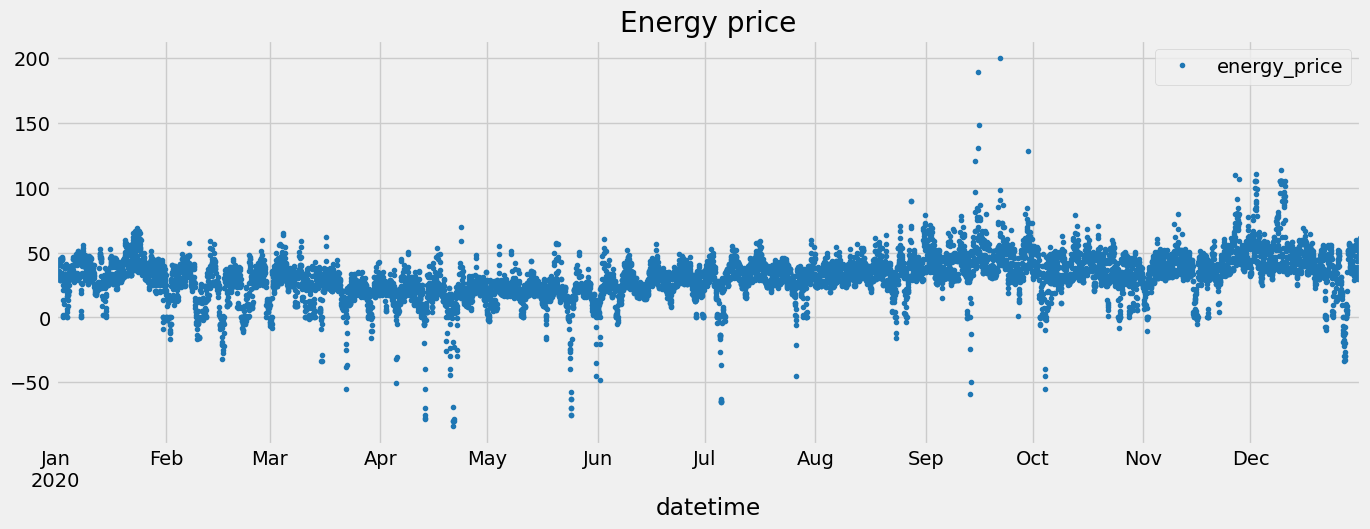

In [5]:
df_energy.plot(
    y='energy_price', 
    style='.', figsize=(15, 5), 
    color=color_pal[0],  # type: ignore
    title='Energy price'
)
plt.show()

## Train / Test Split

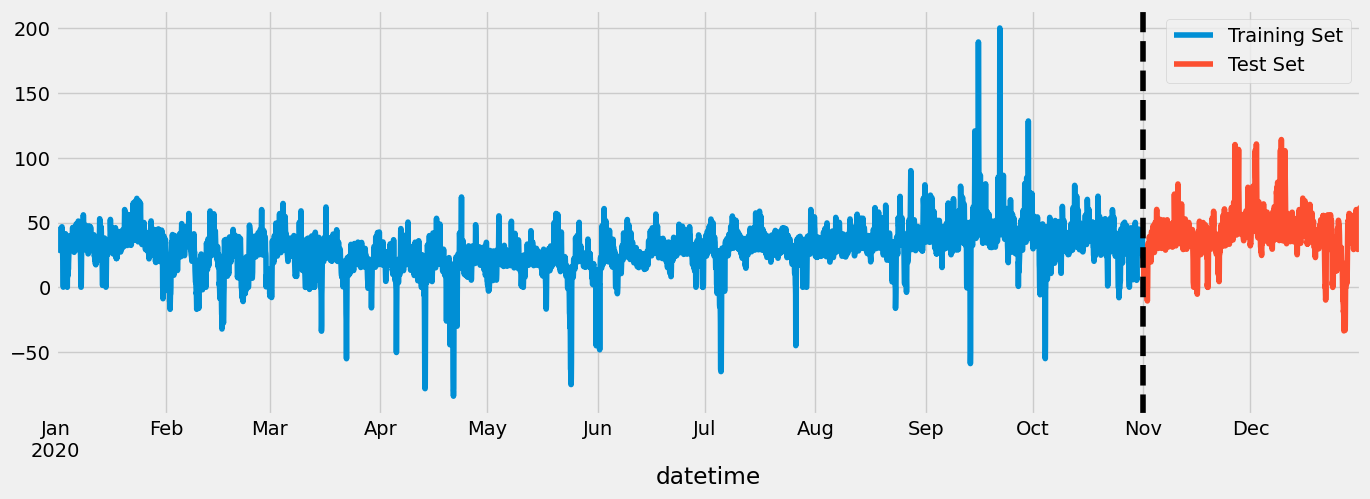

In [6]:
train = df_energy.loc[df_energy.index < '2020-11-01']
test = df_energy.loc[df_energy.index >= '2020-11-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, y='energy_price', label='Training Set')
test.plot(ax=ax, y='energy_price', label='Test Set')
ax.axvline('2020-11-01', color='black', ls='--')
plt.show()

## Create our Model

In [7]:
FEATURES = ['hour', 'month', 'dayofweek']
TARGET = 'energy_price'

In [8]:
X_train=train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [9]:
reg = xgb.XGBRegressor()

In [10]:
# make a dictionary of hyperparameter values to search
search_space = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 6, 9],
    'gamma': [0.01, 0.1],
    'learning_rate': [0.001, 0.01, 0.1],
}

GS = GridSearchCV(estimator = reg,
                  param_grid = search_space,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit = 'r2',
                  cv = 5,
                  verbose=4
)

In [11]:
GS.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-30.135) r2: (test=-2.734) total time=   0.1s
[CV 2/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-22.766) r2: (test=-1.176) total time=   0.1s
[CV 3/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-23.351) r2: (test=-2.219) total time=   0.2s
[CV 4/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-31.309) r2: (test=-4.268) total time=   0.1s
[CV 5/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-39.017) r2: (test=-4.237) total time=   0.1s
[CV 1/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=500; neg_root_mean_squared_error: (test=-25.050) r2: (test=-1.580) total tim

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'gamma': [0.01, 0.1],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 500, 1000]},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'],
             verbose=4)

In [12]:
print(GS.best_estimator_)
print(GS.best_params_)
print(GS.best_score_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
{'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
0.23417390065680205


## Forecast on Test

In [13]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:24.17344	validation_1-rmse:34.44571
[99]	validation_0-rmse:9.21506	validation_1-rmse:18.00511


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [14]:
test['prediction'] = reg.predict(X_test)

/var/folders/cz/cwy65nds1w7_vfh7mtxwrks40000gn/T/ipykernel_5753/2903689382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


In [15]:
df_energy = df_energy.merge(
    test[['prediction']], 
    how='left', left_index=True, 
    right_index=True
)

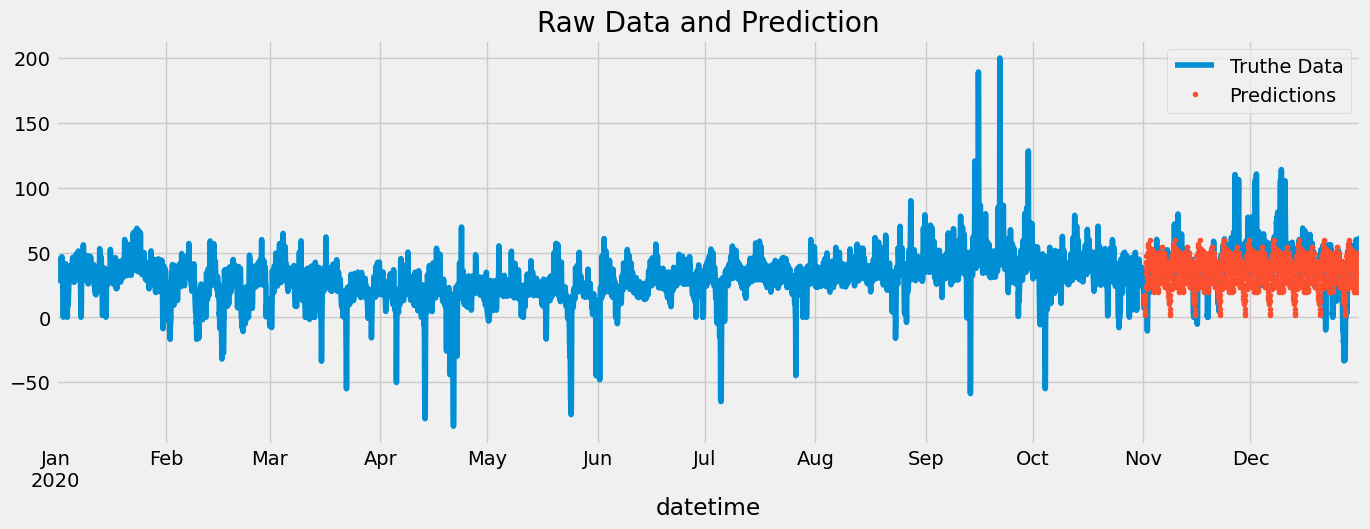

In [16]:
ax = df_energy[['energy_price']].plot(figsize=(15, 5))
df_energy['prediction'].plot(ax=ax, style='.')
plt.legend(['Truthe Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

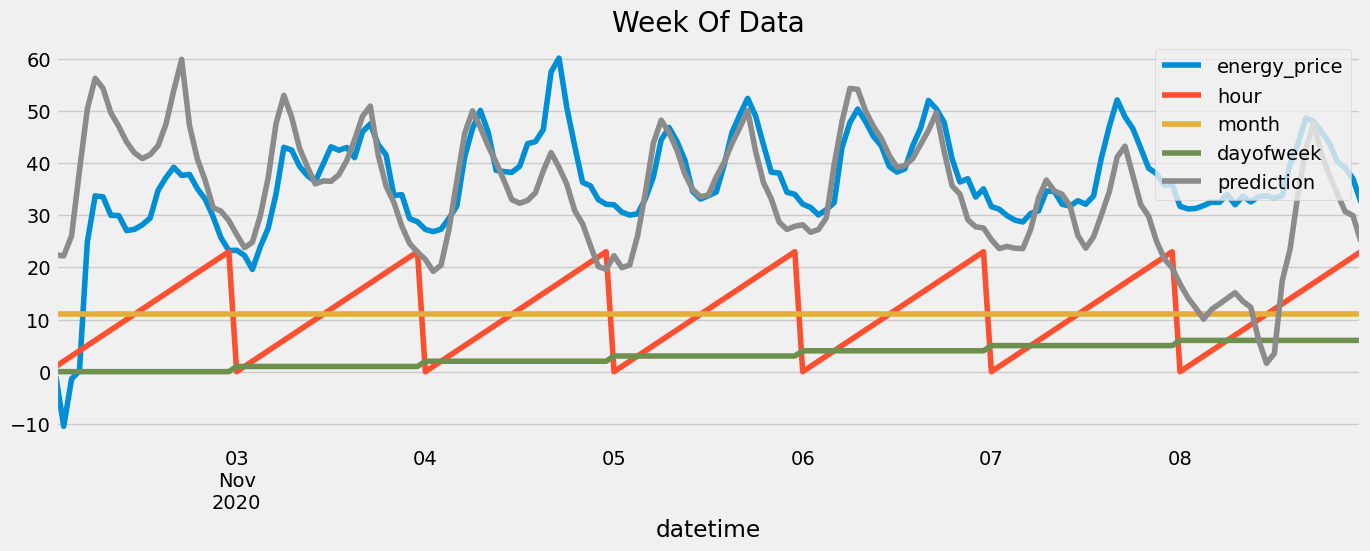

In [17]:
df_energy.loc[(df_energy.index > '2020-11-02') & (df_energy.index < '2020-11-09')].plot(figsize=(15,5), title='Week Of Data')
plt.show()

In [18]:
score = np.sqrt(mean_squared_error(test['energy_price'], test['prediction']))
print(f'RMSE Score on Test set: {score:.2f}')

RMSE Score on Test set: 18.01


In [19]:
reg_hyper = xgb.XGBRegressor(
                            n_estimators=500,
                            base_score=0.5,
                            booster='gbtree',
                            objective='reg:linear',
                            max_depth=3,
                            gamma=0.01,
                            learning_rate=0.01,
                            early_stopping_rounds=50,
)

In [20]:
reg_hyper.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[22:04:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32.08544	validation_1-rmse:44.30482
[100]	validation_0-rmse:16.81730	validation_1-rmse:24.26773
[200]	validation_0-rmse:12.79622	validation_1-rmse:19.14741
[300]	validation_0-rmse:11.73909	validation_1-rmse:17.71603
[400]	validation_0-rmse:11.28049	validation_1-rmse:17.29359
[499]	validation_0-rmse:11.01709	validation_1-rmse:17.18915


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [21]:
test['prediction_with_hyperparams'] = reg.predict(X_test)

/var/folders/cz/cwy65nds1w7_vfh7mtxwrks40000gn/T/ipykernel_5753/3257391019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction_with_hyperparams'] = reg.predict(X_test)


In [22]:
df_energy = df_energy.merge(
    test[['prediction_with_hyperparams']], 
    how='left', left_index=True, 
    right_index=True
)

In [23]:
df_energy

,energy_price,hour,month,dayofweek,date,prediction,prediction_with_hyperparams
datetime,,,,,,,
2020-01-01 00:00:00,38.60,0.0,1.0,2.0,2020-01-01,NaN,NaN
2020-01-01 01:00:00,36.55,1.0,1.0,2.0,2020-01-01,NaN,NaN
2020-01-01 02:00:00,32.32,2.0,1.0,2.0,2020-01-01,NaN,NaN
2020-01-01 03:00:00,30.85,3.0,1.0,2.0,2020-01-01,NaN,NaN
2020-01-01 04:00:00,30.14,4.0,1.0,2.0,2020-01-01,NaN,NaN
...,...,...,...,...,...,...,...
2020-12-31 19:00:00,56.70,19.0,12.0,3.0,2020-12-31,36.305603,36.305603
2020-12-31 20:00:00,52.44,20.0,12.0,3.0,2020-12-31,33.134274,33.134274
2020-12-31 21:00:00,51.86,21.0,12.0,3.0,2020-12-31,28.676767,28.676767


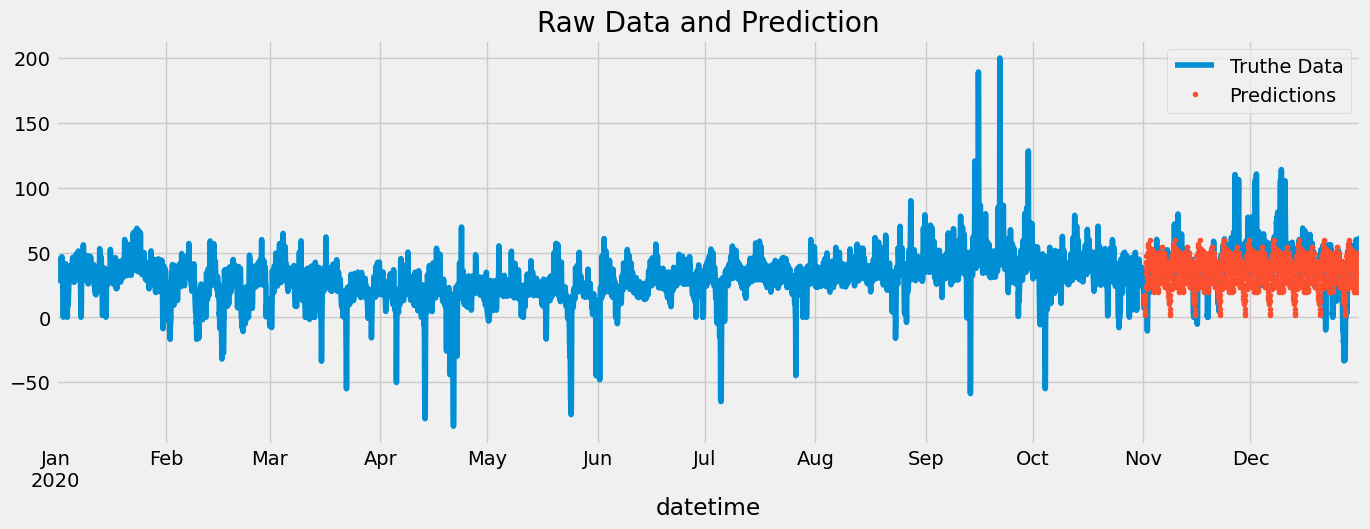

In [24]:
ax = df_energy[['energy_price']].plot(figsize=(15, 5))
df_energy['prediction_with_hyperparams'].plot(ax=ax, style='.')
plt.legend(['Truthe Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

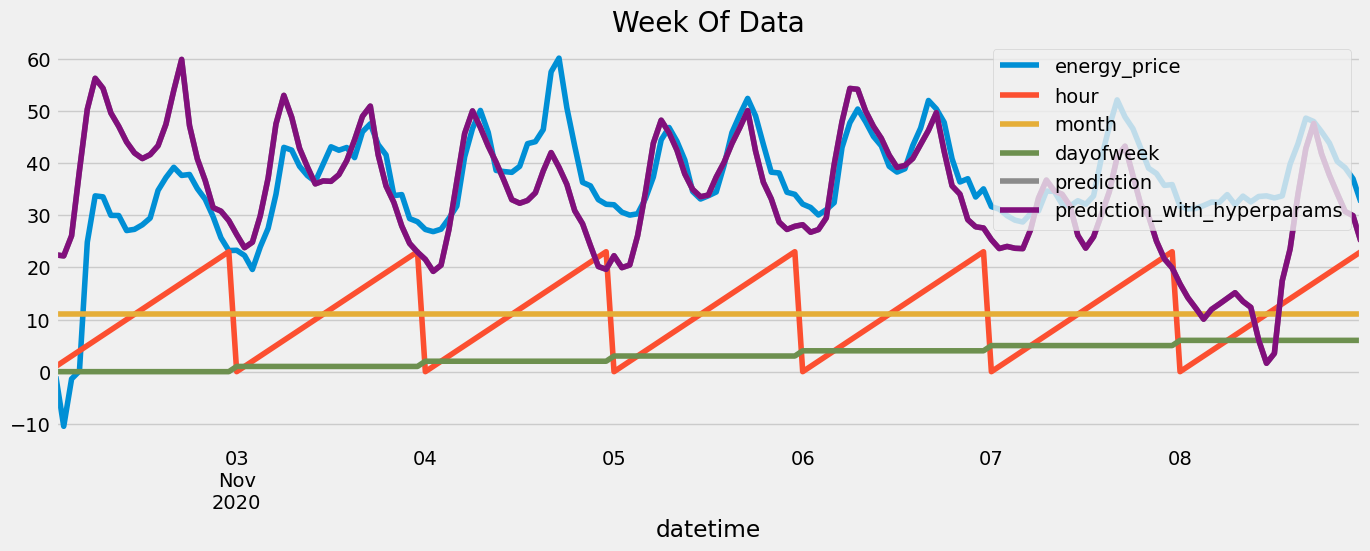

In [25]:
df_energy.loc[(df_energy.index > '2020-11-02') & (df_energy.index < '2020-11-09')].plot(figsize=(15,5), title='Week Of Data')
plt.show()

In [26]:
score = np.sqrt(mean_squared_error(test['energy_price'], test['prediction_with_hyperparams']))
print(f'RMSE Score on Test set: {score:.2f}')

RMSE Score on Test set: 18.01
